# Preprocesado de datos

El preprocesado de datos es una fase indispensable para el correndo aprendizaje por partes de los algoritmos de Deeplearning. Se ha demostrado empíricamente que una correcta preparación y normalización de los datos permiten hallar soluciones más cercanas a la optima que con datos no procesados.

Es importante tener en cuenta que no existe una metodología de preprocesado única, y que es necesario adaptarse al tipo de dato que estamos tratando. Para este proyecto, además, existe una dificultad adicional, y es la existencia de diferentes procedencias para los datos, pues en total se dispone de 5 datasets distintos, cada uno recopilado con diferentes metodologías e instrumentación. Por tanto, será clave adaptarse a cada uno de los destinos, y realizar la partición final de forma estratificada para evitar sesgos que perturben el resutado.

Más adelante, profundizaremos en este aspecto, pero en primer lugar, debemos leer cada uno de los conjuntos de datos disponibles, y examinar de cuántos elementos disponemos en cada uno, para establecer la proporción de entrenamiento-test oportuna.

In [2]:
# Librerías utilizadas por el script
import os
import cv2
import zipfile
import csv
import pathlib
import shutil

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from copy import deepcopy

## Dataset disponibles

Haciendo uso de los recursos disponibles públicamente, se han tomado los siguientes datasets para realizar el experimento:
- ISIC: es el mayor conjuntos de datos cutáneos disponible en abierto, y contiene imágenes de todo tipo de pieles y procedencias, pero con especial énfasis en las personas de origen europeo y americano.
- ASAN: Conjunto de datos provenientes del hospital con este mismo nombre, con lesiones en personas de origen asiático.
- PAD UFES 20: conjunto de datos de lesiones variadas de pacientes latinoamericanos.
- PH2: banco de datos de pacientes brasileños con lesiones potencialmente cancerosas.
- Severance: base de datos con lesiones cutáneas en población asiática, con contenido tanto benigno como cancerígeno.

Para unificar la notación de los datos, se creará un código para la notación de cada una de las clases que permitan un procesamiento común de todos los datos sin depender del origen de este. Para ello, se creará un nuevo archivo .csv donde se anotará el path de la imagen, su clase asociada, y el tipo general de la misma (beningna o maligna). La metainformación asociada, de momento, quedará relegado a un segundo plano hasta el estudio estadístico de los datos.

In [3]:
# Directorios de cada dataset

ISIC_PATH = "datasets/ISIC"
ASAN_PATH = "datasets/Asan"
PAD_UFES_PATH = "datasets/PAD_UFES_20"
PH2_PATH = "datasets/PH2/PH2Dataset"
SEVERANCE_PATH = "datasets/Severance"

In [4]:
# Funciones comunes para la lectura y muestra de datos

'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)
'''


def readIm(filename, flagColor=1):
    # cv2 reads BGR format
    im = cv2.imread(filename)
    # change to  RGB and return the image
    if (flagColor):
        return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # change from BGR to grayscale instead if flag is 0
    return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)


'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''


def rangeDisplay01(im, flag_GLOBAL=True):
    im = im.astype(float)
    if flag_GLOBAL:
        im = (im - im.min()) / (im.max() - im.min())
    else:
        # bands normalization
        for band in range(im.shape[2]):
            im[:, :, band] = (im[:, :, band] - im[:, :, band].min()) / (im[:, :, band].max() - im[:, :, band].min())
            # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
    return im


"""
Función para mostrar imágenes en pantalla en color y blanco negro. Permite realizar
aumento sobre las mismas para apreciar un mayor detalle.

Entrada:
    im: imagen leída en formato ndarray
    title: nombre que recibe el marco en pantalla
    factor: factor de aumento de la image, "zoom"
"""


def displayIm(im, title='Result', factor=2):
    # First normalize range
    max = np.max(im)
    min = np.min(im)
    if min < 0 or max > 255:
        im = rangeDisplay01(im, flag_GLOBAL=True)
    if len(im.shape) == 3:
        # im es tribanda
        plt.imshow(im, cmap='jet')
    else:
        # im es monobanda
        plt.imshow(im, cmap='gray')
    figure_size = plt.gcf().get_size_inches()
    plt.gcf().set_size_inches(factor * figure_size)
    plt.title(title)
    plt.xticks([]), plt.yticks([])  # eliminamos numeración
    plt.show()

### ISIC Skin Dataset

Se trata del dataset de mayor tamaño del conjunto. Contiene 31 clases identificadas, tanto de lesiones benignas y malignas de la piel. En total, se dispone de 53738, las cuales ya han sido filtradas para asegurarse de que no exista redundancia por las herramientas online de la galería ISIC: https://gallery.isic-archive.com/

In [4]:
def extractISIC(path: str):
    # Obtener una lista de todos los archivos ZIP en la carpeta especificada
    archivos_zip = [f for f in os.listdir(path) if f.lower().endswith('.zip')]

    # Iterar sobre cada archivo ZIP
    for archivo_zip in archivos_zip:
        ruta_archivo_zip = os.path.join(path, archivo_zip)
        carpeta_salida = os.path.splitext(ruta_archivo_zip)[0]  # Eliminar la extensión .zip

        # Comprobar si la carpeta de salida ya existe
        if not os.path.exists(carpeta_salida):
            os.makedirs(carpeta_salida)  # Crear la carpeta de salida

            # Extraer el contenido del archivo ZIP en la carpeta de salida
            with zipfile.ZipFile(ruta_archivo_zip, 'r') as zip_ref:
                zip_ref.extractall(carpeta_salida)
            print(f"Extraído {archivo_zip} en {carpeta_salida}")
        else:
            print(f"Omitido {archivo_zip}. {carpeta_salida} ya existe.")


def listar_clases(path):
    # Obtener una lista de todas las carpetas en el path
    return [nombre for nombre in os.listdir(path) if os.path.isdir(os.path.join(path, nombre))]


def definir_etiquetas(path):
    clases = listar_clases(path)
    print(clases)
    return [clase.replace(" ", "_").lower() for clase in clases]


def crear_csv(path, clases, nombre_dataset):
    # Inicializa una lista vacía para almacenar la información de los archivos
    info_archivos = []
    i = 0

    # Itera sobre cada carpeta en la carpeta raíz
    for nombre_carpeta in os.listdir(path):
        ruta_carpeta = os.path.join(path, nombre_carpeta)

        if os.path.isdir(ruta_carpeta):

            # Itera sobre cada archivo en la carpeta
            for nombre_archivo in os.listdir(ruta_carpeta):
                ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)
                if os.path.isfile(
                        ruta_archivo) and nombre_archivo != "metadata.csv" and nombre_archivo != "attribution.txt":
                    # Agrega la información del archivo a la lista
                    info_archivos.append((nombre_archivo, ruta_archivo, clases[i], nombre_dataset))
            i += 1

    # Define la ruta del archivo CSV
    ruta_archivo_csv = "preprocessedData.csv"

    # Escribe la información de los archivos en el archivo CSV
    with open(ruta_archivo_csv, "w", newline="") as archivo_csv:
        escritor_csv = csv.writer(archivo_csv)
        escritor_csv.writerow(["image", "dir", "class", "dataset"])  # Escribe la cabecera
        escritor_csv.writerows(info_archivos)  # Escribe la información de los archivos

In [5]:

# Accedemos al directorio de ISIC
print(os.getcwd())

# Extraemos cada zip, en caso de que no exista
extractISIC(ISIC_PATH)

# Tomamos los nombres de cada imagen, y le asociamos su etiqueta manualmente
print(os.getcwd())

isic_y = definir_etiquetas(ISIC_PATH)

# Creamos CSV
crear_csv(ISIC_PATH, isic_y, "ISIC")
print(os.getcwd())

C:\Users\Cris1\Documents\ETSIIT 8th Stage\TFG
Extraído Acrochordon.zip en datasets/ISIC\Acrochordon
Extraído Actinic keratosis.zip en datasets/ISIC\Actinic keratosis
Extraído AIMP.zip en datasets/ISIC\AIMP
Extraído Angiofibroma or fibreus papule.zip en datasets/ISIC\Angiofibroma or fibreus papule
Extraído Angiokeratoma.zip en datasets/ISIC\Angiokeratoma
Extraído Angioma.zip en datasets/ISIC\Angioma
Extraído Atypical melanocytic proliferation.zip en datasets/ISIC\Atypical melanocytic proliferation
Extraído Atypical spitz tumor.zip en datasets/ISIC\Atypical spitz tumor
Extraído Basal Cell Carcinoma.zip en datasets/ISIC\Basal Cell Carcinoma
Extraído Cafe au lait macule.zip en datasets/ISIC\Cafe au lait macule
Extraído Clear cell acarthoma.zip en datasets/ISIC\Clear cell acarthoma
Extraído Dermatofibroma.zip en datasets/ISIC\Dermatofibroma
Extraído Lentigo NOS.zip en datasets/ISIC\Lentigo NOS
Extraído Lentigo Simplex.zip en datasets/ISIC\Lentigo Simplex
Extraído Lichenoid keratosis.zip en 

### ASAN Dataset

Este dataset es el segundo de mayor tamaño recogido. En total, dispone de 17,125 imágenes de 12 clases distintas. Muchas de estas clases tratan la misma enfermedad, pero distinguen si se ha realizado biopsia o no para verificarlo (aunque todos los resultados han sido confirmados posteriormente tras estudiar su evolución).

La dificultad de este conjunto de datos se debe al formato de almacenaje escogido: todas las imágenes fueron guardadas en estructura de rejilla, provocando la existencia de cientos de imágenes en un mismo espacio separado por bordes blancos. Por tanto, habrá que realizar una etapa de preprocesado más profundo que ISIC para dividir correctamente la imagen y remover los bordes blancos para evitar sesgos en los resultados del modelo final.

El código se divide en dos fases: una primera fase de separación, y la segunda de barajado, donde uniremos el conjunto de entrenamiento y test dividido anteriormente, ya que la proporción elegida para test fue de un apenas 10%, y no se conoce el grado de aleatoriedad del criterio de seperación elegido.

In [6]:
grosor_borde = 8  # Constante del borde a eliminar (px)


# Recortado
def recortarImagenesASAN(path, i, title="ASAN"):
    os.chdir(path)

    files = [f for f in pathlib.Path().iterdir() if f.is_file()][1:]

    names = []
    diss_class = []

    for f in files:
        name = str(f)[str(f).rfind("#") + 1:-4]

        if ".png" in str(f):
            print("Procesando ", name)
            if not os.path.exists(name):
                os.makedirs(name)

            image = cv2.imread(str(f), cv2.IMREAD_UNCHANGED)

            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
            gradient = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, kernel)

            contours, _ = cv2.findContours(gradient, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for cnt in contours:
                (x, y, w, h) = cv2.boundingRect(cnt)
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 0))
                box_image = image[y: y + h, x: x + w]

                # Recorta la imagen para eliminar el borde
                img_sin_borde = box_image[grosor_borde:-grosor_borde, grosor_borde:-grosor_borde]
                cv2.imwrite(f"{name}/{title}_{i}.png", img_sin_borde)

                names.append(f"{title}_{i}.png")
                diss_class.append(name)

                i += 1

    os.chdir("../../../")

    return i

Como el código para crear el fichero CSV ya ha sido creado, sólo debemos añadir las nuevas imágenes al fichero respetando ese formato. 

Para las etiquetas, al tratarse de las mismas enfermedades ya presentes en el dataset de ISIC, debemos asegurarnos que éstas tengan el mismo formato; si cometemos algún error en su escritura, podríamos provocar que el modelo interprete la misma enfermedad como dos distintas.

In [7]:
def aniadir_csv(path, clases, nombre_dataset):
    # Inicializa una lista vacía para almacenar la información de los archivos
    info_archivos = []
    i = 0

    # Itera sobre cada carpeta en la carpeta raíz
    for nombre_carpeta in os.listdir(path):
        ruta_carpeta = os.path.join(path, nombre_carpeta)

        if os.path.isdir(ruta_carpeta):

            # Itera sobre cada archivo en la carpeta
            for nombre_archivo in os.listdir(ruta_carpeta):
                ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)
                if os.path.isfile(
                        ruta_archivo) and nombre_archivo != "metadata.csv" and nombre_archivo != "attribution.txt":
                    # Agrega la información del archivo a la lista
                    info_archivos.append((nombre_archivo, ruta_archivo, clases[i], nombre_dataset))
                    print(nombre_archivo)
            i += 1

    # Define la ruta del archivo CSV
    ruta_archivo_csv = "preprocessedData.csv"

    # Escribe la información de los archivos en el archivo CSV

    with open(ruta_archivo_csv, "a", newline="") as archivo_csv:
        escritor_csv = csv.writer(archivo_csv)
        escritor_csv.writerows(info_archivos)  # Escribe la información de los archivos

Una vez definida la función de adición, podemos proceder a la escritura de las nuevas imágenes y su directorio. Para homogeneizar volver a crear las particiones de train y test, se ha procedido a su merge.

In [8]:
# Ejecutamos la separación del conjunto de train

i = 0  # identificador de imagen

print(os.getcwd())

i = recortarImagenesASAN(ASAN_PATH + "/train_dataset", i)
i = recortarImagenesASAN(ASAN_PATH + "/test_dataset", i)

os.mkdir(ASAN_PATH + "/dataset")

# Fusionamos ambas carpetas
shutil.copytree(ASAN_PATH + "/train_dataset", ASAN_PATH + "/dataset", dirs_exist_ok=True)
shutil.copytree(ASAN_PATH + "/test_dataset", ASAN_PATH + "/dataset", dirs_exist_ok=True)

# Añádimos nuevas etiquetas
asan_y = definir_etiquetas(ASAN_PATH + "/dataset")
aniadir_csv(ASAN_PATH + "/dataset", asan_y, "ASAN")

C:\Users\Cris1\Documents\ETSIIT 8th Stage\TFG
Procesando  actinic keratosis
Procesando  basal cell carcinoma
Procesando  dermatofibroma
Procesando  hemangioma
Procesando  intraepithelial carcinoma
Procesando  lentigo nos
Procesando  melanoma
Procesando  nevus
Procesando  pyogenic granuloma
Procesando  Seborreic Keratosis
Procesando  Squamous cell carcinoma
Procesando  wart
Procesando  actinic keratosis
Procesando  dermatofibroma
Procesando  hemangioma
Procesando  lentigo nos
Procesando  nevus
Procesando  pyogenic granuloma
Procesando  Seborreic Keratosis
Procesando  wart
Procesando  actinic keratosis
Procesando  basal cell carcinoma
Procesando  dermatofibroma
Procesando  hemangioma
Procesando  intraepithelial carcinoma
Procesando  lentigo nos
Procesando  melanoma
Procesando  nevus
Procesando  pyogenic granuloma
Procesando  Seborreic Keratosis
Procesando  Squamous cell carcinoma
Procesando  wart
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'hemangioma', 'intraepitheli

Podemos comprobar en la salida de que todas las clases se han tratado correctamente.

#### Añadido: dataset Hallym

Dentro del fichero que proporcionaba el dataset ASAN, podemos encontrar de forma adicional un pequeño dataset con algunas imágenes extras. Estas pertenecen al dataset de Hallym, el cual recopila sobre 150 imágenes de carcinoma de células basales ubicados en la espalda de diversos pacientes. Para aprovechar este conjunto de datos, podemos operarar de la misma forma que con ASAN, ya que el formato de presentación es el mismo.

Debemos prestar especial atención a los nombres de las clases, ya que en este caso aparecen como "bcc", para denotar la enfermedad. Debemos renombrar la clase a "basal_cell_carcinoma".

In [9]:
i = 0  # identificador de imagen

i = recortarImagenesASAN(ASAN_PATH + "/Hallym_dataset", i, "HALLYM")

# añadimos a nueva carpeta "basal_cell_carcinoma"
# comprobamos primero si    existe para crearla


# movemos las imágenes y borramos las carpetas anteriores
shutil.copytree(ASAN_PATH + "/Hallym_dataset/back bcc", ASAN_PATH + "/Hallym_dataset/basal_cell_carcinoma",
                dirs_exist_ok=True)
shutil.copytree(ASAN_PATH + "/Hallym_dataset/hallym bcc", ASAN_PATH + "/Hallym_dataset/basal_cell_carcinoma",
                dirs_exist_ok=True)

shutil.rmtree(ASAN_PATH + "/Hallym_dataset/back bcc")
shutil.rmtree(ASAN_PATH + "/Hallym_dataset/hallym bcc")

hallym_y = definir_etiquetas(ASAN_PATH + "/Hallym_dataset")

#global_y = global_y.union(set(hallym_y))

aniadir_csv(ASAN_PATH + "/Hallym_dataset/", hallym_y, "HALLYM")

Procesando  back bcc
Procesando  hallym bcc
['basal_cell_carcinoma']
HALLYM_0.png
HALLYM_1.png
HALLYM_10.png
HALLYM_100.png
HALLYM_101.png
HALLYM_102.png
HALLYM_103.png
HALLYM_104.png
HALLYM_105.png
HALLYM_106.png
HALLYM_107.png
HALLYM_108.png
HALLYM_109.png
HALLYM_11.png
HALLYM_110.png
HALLYM_111.png
HALLYM_112.png
HALLYM_113.png
HALLYM_114.png
HALLYM_115.png
HALLYM_116.png
HALLYM_117.png
HALLYM_118.png
HALLYM_119.png
HALLYM_12.png
HALLYM_120.png
HALLYM_121.png
HALLYM_122.png
HALLYM_123.png
HALLYM_124.png
HALLYM_125.png
HALLYM_126.png
HALLYM_127.png
HALLYM_128.png
HALLYM_129.png
HALLYM_13.png
HALLYM_130.png
HALLYM_131.png
HALLYM_132.png
HALLYM_133.png
HALLYM_134.png
HALLYM_135.png
HALLYM_136.png
HALLYM_137.png
HALLYM_138.png
HALLYM_139.png
HALLYM_14.png
HALLYM_140.png
HALLYM_141.png
HALLYM_142.png
HALLYM_143.png
HALLYM_144.png
HALLYM_145.png
HALLYM_146.png
HALLYM_147.png
HALLYM_148.png
HALLYM_149.png
HALLYM_15.png
HALLYM_150.png
HALLYM_151.png
HALLYM_16.png
HALLYM_17.png
HALLYM_18.png

### PAD UFES 20

Se trata de un dataset diseñado para el entramiento de sistemas de asistencia en diagnóstico computado, donde el experto dermatólogo puede utilizarlo como un medio de apoyo. Contiene 6 enfermedades distintas, siendo 3 cancerosas (células basales, células escamosas o melanoma maligno) y 3 benignas (actinic keratosis, nevus, keratosis seborreica).

Todos los casos cancerosos han sido probados mediante biopsia, por lo que tenemos total certeza de los resultados recopilados. A su vez, también contenemos gran cantidad de metados asociados a la edad, antencedentes familiares, hábitos, entre otros.

#### Estructura de los datos
La organización de las imágenes es más sencilla que ASAN, pues las imágenes son individuales. Además, dispone de un fichero CSV adecuadamente organizado. La única modificación necesaria es actualizar el path de cada imagen y la nomenclatura del diagnóstico de la enfermedad por la ya utilizada.

In [10]:
# Lectura del csv dado
df_pad_ufes = pd.read_csv(PAD_UFES_PATH + '/metadata.csv')
display(df_pad_ufes)

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,PAT_1708,3156,NaN,NaN,NaN,NaN,73,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1708_3156_175.png,False
2294,PAT_46,880,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,12.0,BCC,True,True,False,True,False,False,PAT_46_880_140.png,True
2295,PAT_1343,1217,NaN,NaN,NaN,NaN,74,NaN,NaN,NaN,...,NaN,SEK,False,False,False,False,False,False,PAT_1343_1217_404.png,False
2296,PAT_326,690,False,False,POMERANIA,POMERANIA,58,True,FEMALE,True,...,4.0,BCC,True,False,False,False,False,True,PAT_326_690_823.png,True


In [11]:
# Modificamos las etiquetas
df_pad_ufes['diagnostic'] = df_pad_ufes['diagnostic'].replace(
    {'BCC': 'basal_cell_carcinoma', 'SEK': 'seborreic_keratosis', 'SCC': 'squamous_cell_carcinoma', 'NEV': 'nevus',
     'ACK': 'actinic_keratosis', 'MEL': 'melanoma'})

df_pad_ufes['im_dir'] = df_pad_ufes['img_id'].apply(lambda x: PAD_UFES_PATH + '/images/' + x)
df_pad_ufes['dataset'] = 'PAD_UFES'
display(df_pad_ufes)

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed,im_dir,dataset
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,False,False,False,False,False,False,PAT_1516_1765_530.png,False,datasets/PAD_UFES_20/images/PAT_1516_1765_530.png,PAD_UFES
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,True,True,False,True,True,True,PAT_46_881_939.png,True,datasets/PAD_UFES_20/images/PAT_46_881_939.png,PAD_UFES
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,...,True,False,False,False,False,False,PAT_1545_1867_547.png,False,datasets/PAD_UFES_20/images/PAT_1545_1867_547.png,PAD_UFES
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,...,True,False,False,False,False,False,PAT_1989_4061_934.png,False,datasets/PAD_UFES_20/images/PAT_1989_4061_934.png,PAD_UFES
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,True,True,False,False,True,True,PAT_684_1302_588.png,True,datasets/PAD_UFES_20/images/PAT_684_1302_588.png,PAD_UFES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,PAT_1708,3156,NaN,NaN,NaN,NaN,73,NaN,NaN,NaN,...,True,False,False,False,False,False,PAT_1708_3156_175.png,False,datasets/PAD_UFES_20/images/PAT_1708_3156_175.png,PAD_UFES
2294,PAT_46,880,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,True,True,False,True,False,False,PAT_46_880_140.png,True,datasets/PAD_UFES_20/images/PAT_46_880_140.png,PAD_UFES
2295,PAT_1343,1217,NaN,NaN,NaN,NaN,74,NaN,NaN,NaN,...,False,False,False,False,False,False,PAT_1343_1217_404.png,False,datasets/PAD_UFES_20/images/PAT_1343_1217_404.png,PAD_UFES
2296,PAT_326,690,False,False,POMERANIA,POMERANIA,58,True,FEMALE,True,...,True,False,False,False,False,True,PAT_326_690_823.png,True,datasets/PAD_UFES_20/images/PAT_326_690_823.png,PAD_UFES


Ahora, solo quedaría añadir la información al csv global manteniendo el formato establecido

In [12]:
df_final_pad_ufes = df_pad_ufes[['img_id', 'im_dir', 'diagnostic', 'dataset']].to_numpy()
with open("preprocessedData.csv", "a", newline="") as archivo_csv:
    escritor_csv = csv.writer(archivo_csv)
    escritor_csv.writerows(df_final_pad_ufes)  # Escribe la información de los archivos

### PH2

 Este dataset recoge imágenes provenientes del Servicio de Dermatología del Hospital Pedro Hispano (Matosinhos, Portugal), que recoge pruebas cutáneas realizadas con el sistema Tuebinger Mole Analyzer, y un aumento de 20x. Son imágenes a color de triple canal con una resolución de 768x560 píxeles.

Esta base de datos de imágenes contiene un total de 200 imágenes dermatoscópicas de lesiones melanocíticas, incluidos 80 lunares comunes, 80 nevus atípicos y 40 melanomas. La base de datos PH² incluye anotaciones médicas de todas las imágenes: segmentación médica de la lesión, diagnóstico clínico e histológico, y evaluación de varios criterios dermatoscópicos. Entre ellos, encontramos distinción por colores; formación del tejido; puntos/glóbulos; rayas; áreas de regresión; velo azul blanquecino (pgimentación difusa).

#### Estructura de los datos
 
Este datset se organiza por carpetas codificadas, donde encontrarmos en su interior la imagen dermoscópica, la plantilla de segmentación y otras regiones de interés en directorios diferentes. En nuestro caso, seleccionaremos de momento únicamente las imágenes presentes en el directorio de imagen dermoscópica, que contiene la lesión en sí.

Se procede a la lectura del fichero csv que contiene los metadatos, y la adición de todas las entradas de archivos a la tabla común de todos los datasets.

In [13]:
# Lectura del csv dado
df_ph2 = pd.read_excel(PH2_PATH + '/PH2_dataset.xlsx', skiprows=range(0, 12))
display(df_ph2)

,Image Name,Histological Diagnosis,Common Nevus,Atypical Nevus,Melanoma,Asymmetry\n(0/1/2),Pigment Network\n(AT/T),Dots/Globules\n(A/AT/T),Streaks\n(A/P),Regression Areas\n(A/P),Blue-Whitish Veil\n(A/P),White,Red,Light-Brown,Dark-Brown,Blue-Gray,Black
0,IMD003,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,NaN,X,NaN,NaN
1,IMD009,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,X,NaN,NaN,NaN
2,IMD016,NaN,X,NaN,NaN,0,T,T,A,A,A,NaN,NaN,X,X,NaN,NaN
3,IMD022,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,X,NaN,NaN,NaN
4,IMD024,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,X,X,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,IMD424,Melanoma,NaN,NaN,X,2,AT,AT,P,A,P,NaN,NaN,X,X,X,X
196,IMD425,Melanoma,NaN,NaN,X,2,AT,AT,A,P,P,NaN,NaN,X,X,X,X
197,IMD426,Melanoma,NaN,NaN,X,2,AT,A,A,P,A,NaN,NaN,X,X,NaN,NaN
198,IMD429,NaN,NaN,NaN,X,0,AT,A,P,A,P,NaN,NaN,X,X,X,X


Las columnas que contienen una x son aquellas que indican la clase del lunar que se está observando. Puede ser un lunar atípico, o un lunar o comun, o un melanoma. Codificaremos los tres tipos adecuadamente para construir un nuevo csv del que realizar la mezcla y separación train-test.

In [14]:
new_labels_ph2 = []
for index, row in df_ph2.iterrows():
    # Actualizar los valores de las columnas según alguna lógica
    if row['Common Nevus'] == 'X':
        new_labels_ph2.append("nevus")
    elif row['Atypical Nevus'] == 'X':
        new_labels_ph2.append("atypical nevus")
    elif row['Melanoma'] == 'X':
        new_labels_ph2.append("melanoma")

# Adjuntamos la nueva columna a las columnas a conservar
df_ph2["class"] = new_labels_ph2

Ahora, sólo debemos extraer las columnas deseadas e insertar los valores al csv global.

In [15]:

df_ph2['im_dir'] = df_ph2['Image Name'].apply(
    lambda x: PH2_PATH + '/PH2 Dataset images/' + x + f"/{x}_Dermoscopic_Image/" + x + ".bmp")
df_ph2['dataset'] = 'PH2'
#display(df_ph2)

df_final_ph2 = df_ph2[['Image Name', 'im_dir', 'class', 'dataset']].to_numpy()

with open("preprocessedData.csv", "a", newline="") as archivo_csv:
    escritor_csv = csv.writer(archivo_csv)
    escritor_csv.writerows(df_final_ph2)  # Escribe la información de los archivos

De esta forma, conseguimos añadir todas las imágenes de este dataset al conjunto global.

### Severance Dataset

Este dataset, como ya se comentó,viene de parte del hospital Severance, y posee una gran cantida de imágenes a patologías de la piel. El formato de este repositorio sigue una estructura similar a la de ASAN: las imágenes están organizadas en varias páginas de gran tamaño, donde, a diferencia de ASAN, podemos encontrar varias imágenes por lesión separadas entre cuadros blancos. 

Dejando de lado este detalle, el proceso a seguir es muy similar:
- Procedemos a la lectura de todas las imágenes del repositorio
- Separamos las miniaturas y las introducimos en el dataset.
- Mientras estas se recortan, se almacena la información acerca del tipo de enfermedad de la que se trata.

Existen distintas versiones y subconjuntos de este dataset, pero el subconjunto A es el que contiene el grueso de los datos, además de tratarse del único público de su repositorio.

In [24]:
# Lectura de las imágenes y del csv asociado.
df_sev = pd.read_excel(SEVERANCE_PATH + '/SeveranceA.xls', header=None)
display(df_sev)

,0,1,2,3,4,5,6
0,actinickeratosis,60,M,R/O AK\nR/O SCC,actinickeratosis;squamouscellcarcinoma;,Lt. cheek,Head&Neck
1,actinickeratosis,68,F,R/O AK,actinickeratosis;,perioral area,Head&Neck
2,actinickeratosis,39,F,R/O AK\nR/O SK,actinickeratosis;seborrheickeratosis;,nose,Head&Neck
3,actinickeratosis,63,F,R/O AK,actinickeratosis;,cheek,Head&Neck
4,actinickeratosis,66,F,R/O SK\nR/O AK,seborrheickeratosis;actinickeratosis;,nose,Head&Neck
...,...,...,...,...,...,...,...
10421,spitznevus,18,F,R/O inflammed intradermal nevus,melanocyticnevus;,cheek,Head&Neck
10422,spitznevus,13,F,R/O GP,pyogenicgranuloma;,Lt. calf,Leg
10423,spitznevus,14,F,R/O spitz nevus,otherbenign;,lower leg,Leg
10424,spitznevus,8,M,R/O hemangioma,hemangioma;,Rt. thigh,Leg


#### Método para la separación de imagenes

Debido a las imágenes en blanco insertadas entre las miniaturas, no será posible reutilizar la función de recorte empleada con el dataset de ASAN. Por tanto, debemos de reimplementar una nueva función capaz de tenerlos en cuenta y entiquetar con la label que indique dicho recuadro todas las imágenes de tejidos que se encuentren hasta el siguiente recuadro.

In [25]:
grosor_borde = 8  # Constante del borde a eliminar (px)


# Recortado
def recortarImagenesSEVERANCE(path):
    #Creamos directorio de imágenes recortadas
    os.chdir(path)
    df_sev = pd.read_excel('SeveranceA.xls', header=None)

    if not os.path.exists('thumbnails'):
        os.makedirs('thumbnails')

    # Listamos las imágenes en rejilla disponibles
    files = [f for f in pathlib.Path().iterdir() if f.is_file()]

    names = []
    diss_class = []
    j = -1

    trainProcessed = []

    for f in files:
        if "jpg" in str(f):
            #Retiramos la extensión del fichero
            name = str(f)[:-4]

            # Leemos la imagen
            image = cv2.imread(str(f), cv2.IMREAD_UNCHANGED)[2:-6]

            # Dividimos la rejilla
            image_split = np.split(image[1:-1], 8)

            i = 0
            for im in image_split:
                # Recorta la imagen en columnas
                image_split_col = np.split(im[:, 2:-3], 15, axis=1)
                # Para cada imagen
                for imcol in image_split_col:
                    # Eliminar el borde
                    img_sin_borde = imcol[grosor_borde:-grosor_borde, grosor_borde:-grosor_borde]
                    if (np.count_nonzero(imcol == 255) > 20000):  # Si es imagen de separador con nombre
                        j += 1  # Cambiamos de etiqueta al siguiente paciente
                        continue
                    else:
                        actual = list(df_sev.iloc[j])
                        actual.append(f"{name}_{i}.png")
                        trainProcessed.append(actual)
                    # Guardamos la imagen y añadimos su nombre
                    cv2.imwrite(f"thumbnails/{name}_{i}.png", img_sin_borde)
                    names.append(f"{name}_{i}.png")
                    i += 1

                diss_class.append(name)

    print("Miniaturas separadas")
    # Creamos el dataframe con las imágenes recortadas
    trainProcessedDF = pd.DataFrame(trainProcessed)
    trainProcessedDF.columns = ["label", "age", "sex", "abrev_diagnosis", "diagnosis", "fine_loc", "loc", "image"]

    # Salvamos a disco duro la información
    trainProcessedDF.to_csv("severanceTrainingSet_thumbnails.csv", sep=',', encoding='utf-8')

    print("Fichero creado correctamente")

    os.chdir("../../")

Ahora, ya tenemos las imágenes en un formato manejable para las herramientas de las que disponemos, haciendo uso del nuevo fichero csv que contiene la metainformación y las clases.

In [26]:
# Obtenemos las miniaturas
recortarImagenesSEVERANCE(SEVERANCE_PATH)

Miniaturas separadas
Fichero creado correctamente


In [19]:
df_sev = pd.read_csv(SEVERANCE_PATH + '/severanceTrainingSet_thumbnails.csv')
display(df_sev)

,Unnamed: 0,label,age,sex,abrev_diagnosis,diagnosis,fine_loc,loc,image
0,0,actinickeratosis,60,M,R/O AK\nR/O SCC,actinickeratosis;squamouscellcarcinoma;,Lt. cheek,Head&Neck,001_0.png
1,1,actinickeratosis,60,M,R/O AK\nR/O SCC,actinickeratosis;squamouscellcarcinoma;,Lt. cheek,Head&Neck,001_1.png
2,2,actinickeratosis,60,M,R/O AK\nR/O SCC,actinickeratosis;squamouscellcarcinoma;,Lt. cheek,Head&Neck,001_2.png
3,3,actinickeratosis,60,M,R/O AK\nR/O SCC,actinickeratosis;squamouscellcarcinoma;,Lt. cheek,Head&Neck,001_3.png
4,4,actinickeratosis,68,F,R/O AK,actinickeratosis;,perioral area,Head&Neck,001_4.png
...,...,...,...,...,...,...,...,...,...
35165,35165,spitznevus,8,F,R/O Spitz nevus,otherbenign;,abdomen,Trunk,380_88.png
35166,35166,spitznevus,8,F,R/O Spitz nevus,otherbenign;,abdomen,Trunk,380_89.png
35167,35167,spitznevus,8,F,R/O Spitz nevus,otherbenign;,abdomen,Trunk,380_90.png
35168,35168,spitznevus,8,F,R/O Spitz nevus,otherbenign;,abdomen,Trunk,380_91.png


In [20]:
print(df_sev['label'].unique())

['actinickeratosis' 'angiofibroma' 'angiokeratoma' 'basalcellcarcinoma'
 'beckernevus' 'bluenevus' 'bowendisease' 'cafeaulaitmacule'
 'congenitalnevus' 'melanocyticnevus' 'dermatofibroma' 'epidermalcyst'
 'epidermalnevus' 'wart' 'hemangioma' 'juvenilexanthogranuloma'
 'keratoacanthoma' 'lentigo' 'seborrheickeratosis' 'lymphangioma'
 'venouslake' 'malignantmelanoma' 'milia' 'mucocele'
 'mucosalmelanoticmacule' 'neurofibroma' 'nevusspilus' 'organoidnevus'
 'sebaceoushyperplasia' 'otanevus' 'porokeratosis' 'poroma'
 'portwinestain' 'pyogenicgranuloma' 'skintag' 'squamouscellcarcinoma'
 'syringoma' 'xanthelasma' 'angiosarcoma' 'dfsp' 'kaposisarcoma'
 'merkelcellcarcinoma' 'spitznevus']


Para hacer que las clases coincidan con las ya etiquetadas hasta el momento, debemos realizar una conversión de nomenclatura. Esta tarea la realizaré con un diccionario, el cual transformará el formato de etiquetas propuesto por el sistema original al sistema de identificación que estamos usando, el cual toma como base la nomenclatura ISIC al ser el subconjunto mayoritario del dataset.

In [21]:
# Modificamos las etiquetas
df_sev['label'] = df_sev['label'].replace(
    {
        'actinickeratosis': 'actinic_keratosis',
        'angiofibroma': 'angiofibroma',
        'angiokeratoma': 'angiokeratoma',
        'basalcellcarcinoma': 'basal_cell_carcinoma',
        'beckernevus': 'becker_nevus',
        'bluenevus': 'blue_nevus',
        'bowendisease': 'squamous_cell_carcinoma',
        'cafeaulaitmacule': 'cafe_au_lait_macule',
        'congenitalnevus': 'congenital_nevus',
        'melanocyticnevus': 'melanocytic_nevus',
        'dermatofibroma': 'dermatofibroma',
        'epidermalcyst': 'epidermal_cyst',
        'epidermalnevus': 'epidermal_nevus',
        'wart': 'wart',
        'hemangioma': 'hemangioma',
        'juvenilexanthogranuloma': 'juvenile_xanthogranuloma',
        'keratoacanthoma': 'keratoacanthoma',
        'lentigo': 'lentigo_nos',
        'seborrheickeratosis': 'seborreic_keratosis',
        'lymphangioma': 'lymphangioma',
        'venouslake': 'venous_lake',
        'malignantmelanoma': 'melanoma_metastatis',
        'milia': 'milia',
        'mucocele': 'mucocele',
        'mucosalmelanoticmacule': 'mucosal_melanotic_macule',
        'neurofibroma': 'neurofibroma',
        'nevusspilus': 'nevus_spilus',
        'organoidnevus': 'organoid_nevus',
        'sebaceoushyperplasia': 'sebaceous_hyperplasia',
        'otanevus': 'ota_nevus',
        'porokeratosis': 'poro_keratosis',
        'poroma': 'poroma',
        'portwinestain': 'port_wine_stain',
        'pyogenicgranuloma': 'pyogenic_granuloma',
        'skintag': 'skin_tag',
        'squamouscellcarcinoma': 'squamous_cell_carcinoma',
        'syringoma': 'syringoma',
        'xanthelasma': 'xanthelasma',
        'angiosarcoma': 'angiosarcoma',
        'dfsp': 'dfsp',
        'kaposisarcoma': 'kaposi_sarcoma',
        'merkelcellcarcinoma': 'merkel_cell_carcinoma',
        'spitznevus': 'spitz_nevus'
    })

df_sev['im_dir'] = df_sev['image'].apply(lambda x: SEVERANCE_PATH + '/thumbnails/' + x)
df_sev['dataset'] = 'SEVERANCE'
display(df_sev)

,Unnamed: 0,label,age,sex,abrev_diagnosis,diagnosis,fine_loc,loc,image,im_dir,dataset
0,0,actinic_keratosis,60,M,R/O AK\nR/O SCC,actinickeratosis;squamouscellcarcinoma;,Lt. cheek,Head&Neck,001_0.png,datasets/Severance/thumbnails/001_0.png,SEVERANCE
1,1,actinic_keratosis,60,M,R/O AK\nR/O SCC,actinickeratosis;squamouscellcarcinoma;,Lt. cheek,Head&Neck,001_1.png,datasets/Severance/thumbnails/001_1.png,SEVERANCE
2,2,actinic_keratosis,60,M,R/O AK\nR/O SCC,actinickeratosis;squamouscellcarcinoma;,Lt. cheek,Head&Neck,001_2.png,datasets/Severance/thumbnails/001_2.png,SEVERANCE
3,3,actinic_keratosis,60,M,R/O AK\nR/O SCC,actinickeratosis;squamouscellcarcinoma;,Lt. cheek,Head&Neck,001_3.png,datasets/Severance/thumbnails/001_3.png,SEVERANCE
4,4,actinic_keratosis,68,F,R/O AK,actinickeratosis;,perioral area,Head&Neck,001_4.png,datasets/Severance/thumbnails/001_4.png,SEVERANCE
...,...,...,...,...,...,...,...,...,...,...,...
35165,35165,spitz_nevus,8,F,R/O Spitz nevus,otherbenign;,abdomen,Trunk,380_88.png,datasets/Severance/thumbnails/380_88.png,SEVERANCE
35166,35166,spitz_nevus,8,F,R/O Spitz nevus,otherbenign;,abdomen,Trunk,380_89.png,datasets/Severance/thumbnails/380_89.png,SEVERANCE
35167,35167,spitz_nevus,8,F,R/O Spitz nevus,otherbenign;,abdomen,Trunk,380_90.png,datasets/Severance/thumbnails/380_90.png,SEVERANCE
35168,35168,spitz_nevus,8,F,R/O Spitz nevus,otherbenign;,abdomen,Trunk,380_91.png,datasets/Severance/thumbnails/380_91.png,SEVERANCE


In [22]:
df_final_sev = df_sev[['image', 'im_dir', 'label', 'dataset']].to_numpy()
with open("preprocessedData.csv", "a", newline="") as archivo_csv:
    escritor_csv = csv.writer(archivo_csv)
    escritor_csv.writerows(df_final_sev)  # Escribe la información de los archivos

## Dataset Resultante

Una vez realizado el proceso de adaptación de los distintos conjuntos en un único fichero, ya disponemos de un conjunto de datos organizado y bajo la misma nomenclatura que puede ser fácilemte procesable. Gracias a mantener los lugares de procedencia de cada imagen, además, podremos realizar la partición de forma estratificada, evitando así sesgos indeseados por parte del algoritmo.

In [30]:
# Leemos el fichero final
dataset_df = pd.read_csv('preprocessedData.csv')
display(dataset_df)

,image,dir,class,dataset
0,ISIC_0012249.JPG,datasets/ISIC\Acrochordon\ISIC_0012249.JPG,acrochordon,ISIC
1,ISIC_0013368.JPG,datasets/ISIC\Acrochordon\ISIC_0013368.JPG,acrochordon,ISIC
2,ISIC_0021126.JPG,datasets/ISIC\Acrochordon\ISIC_0021126.JPG,acrochordon,ISIC
3,ISIC_0021127.JPG,datasets/ISIC\Acrochordon\ISIC_0021127.JPG,acrochordon,ISIC
4,ISIC_0021128.JPG,datasets/ISIC\Acrochordon\ISIC_0021128.JPG,acrochordon,ISIC
...,...,...,...,...
108237,380_88.png,datasets/Severance/thumbnails/380_88.png,spitz_nevus,SEVERANCE
108238,380_89.png,datasets/Severance/thumbnails/380_89.png,spitz_nevus,SEVERANCE
108239,380_90.png,datasets/Severance/thumbnails/380_90.png,spitz_nevus,SEVERANCE
108240,380_91.png,datasets/Severance/thumbnails/380_91.png,spitz_nevus,SEVERANCE


# Super resolution para imágenes pequeñas

Las imágenes procedentes de buena parte de los datasets poseen una buena resolución, siendo esta prácticamente lo que se conoce como alta resolución en aprendizaje profundo (1024 x 1024). Sin embargo, aquellas imágenes pertenecientes a los datasets Severance y ASAN, que fueron almacenadas en forma de matriz de imágenes, poseen una calidad muy pobre, de apenas 98x98 píxeles. Esto podría crear cierto sesgo en el aprendizaje, por lo que una buena técnica para evitarlo es conseguir aumentar su tamaño, pero sin afectar a su nitidez.

Un simple reescalado solo provocarían altas frecuencias en la imagen que colaborarían en la aportación de ruido al modelo. Hacen falta técnicas más avanzadas, como la utilización de redes generativas adversarias (GANs).
 
En este tipo de arquitectura, una red generará una imagen sintética, la cual será validada por otra, que establecerá si la imagen recibida es considerada como verídica o no. A estas redes se le llaman generador y discriminador, respectivamente. Se utilizan ampliamente para la generación de nuevos datos sintéticos para ser utilizados como entrenamiento, y se considera una técnica de data augmentation. Sin embargo, estas también pueden emplearse en el rescalado de resolución de imágenes.



## ESRGAN

Para llevar a cabo la mejora de calidad de imágenes, utilizaremos el modelo preentrenado Enhanced Super Resolution GAN (ESRGAN), publicada en 2018. Esta red ha demostrado cuantiosos éxistos en la literatura al ser utilizada como forma de reescalado de datos, debido a sus mejoras propuestas frente a las GANs tradicionales. Una de las claves reside en la función de pérdida; en lugar de discriminar si la imagen es adecuada o no, se ha empleado un "grado de percepción" (Perceptual Loss) de la imagen, donde se discrimina la calidad de la imagen generada en una escala. Ademñas, incorpora a la arquitectura las conexiones residuales al estilo de RESNET, pero con la diferencia de que todos los niveles de un bloque están conectados a todas las siguientes una conexión residual, arquitectura la cual han denominado Residual-in-Residual. Esto les ha permitido evitar la decaída de gradiente, y ademñás, prescindir de la capa de Batch Normalization, que introducía ruido en el resultado final, creando artefactos, debido a la tendencia que tiene a equilibrar la media y desviación típica a nivel de batch.

Podemos encontrar en github el repositorio asociado a este modelo (https://github.com/xinntao/ESRGAN), que incluye un modelo preentrenado para reescalar a un x4 las imágenes de entrada.

En esta sección, valoraremos su aplicación para el modelo final, y conseguir equilibrar la resolución de todas las imágenes.

## Implementación

La implementación del modelo podemos importarla del repositirio de github. La única tarea que debemos realizar es conseguir detectar qué imágenes requieren un incremento de resolución y aplicárselo. Como ya sabemos, sólo ASAN y Severance requieren dicho tratamiento, por lo que filtraremos el dataset en búsqueda de estas imágenes.

In [5]:
# Importar modelo

import os.path as osp
import glob
import cv2
import numpy as np
import torch
from ESRGAN import RRDBNet_arch as arch

In [6]:
def read_images(im_path, im_out):
    im_path += "/*"
    model_path = 'ESRGAN/models/RRDB_ESRGAN_x4.pth'  # models/RRDB_ESRGAN_x4.pth OR models/RRDB_PSNR_x4.pth
    device = torch.device('cuda')  # if you want to run on CPU, change 'cuda' -> cpu
    # device = torch.device('cpu')
    print("Ejecuando en: ", device)

    model = arch.RRDBNet(3, 3, 64, 23, gc=32)
    model.load_state_dict(torch.load(model_path), strict=True)
    model.eval()
    model = model.to(device)

    print('Model path {:s}. \nRescalando...'.format(model_path))

    idx = 0
    for path in glob.glob(im_path):
        idx += 1
        base = osp.splitext(osp.basename(path))[0]
        print(idx, base)
        # read images
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = img * 1.0 / 255
        img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
        img_LR = img.unsqueeze(0)
        img_LR = img_LR.to(device)

        with torch.no_grad():
            output = model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
        output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
        output = (output * 255.0).round()
        cv2.imwrite(f'{im_out}/' + '{:s}.png'.format(base), output)

In [7]:
def reescalar_img(path_orig, nombre_carp):
    # Renombrar la carpeta

    if not os.path.exists(nombre_carp):
        # Renombrar la carpeta
        os.rename(path_orig, nombre_carp)

        # Creamos carpeta con mismo nombre para no modificar csv
        os.mkdir(path_orig)

        read_images(path_orig + "_lr", path_orig)

    else:
        print(f"La carpeta '{nombre_carp}' ya existe.")

In [34]:
# Realizamos la reescalada de Severance
sev_orig = SEVERANCE_PATH + "/thumbnails"
reescalar_img(sev_orig, sev_orig + "_lr")

Ejecuando en:  cuda
Model path ESRGAN/models/RRDB_ESRGAN_x4.pth. 
Rescalando...
1 001_0
2 001_1
3 001_10
4 001_11
5 001_12
6 001_13
7 001_14
8 001_15
9 001_16
10 001_17
11 001_18
12 001_19
13 001_2
14 001_20
15 001_21
16 001_22
17 001_23
18 001_24
19 001_25
20 001_26
21 001_27
22 001_28
23 001_29
24 001_3
25 001_30
26 001_31
27 001_32
28 001_33
29 001_34
30 001_35
31 001_36
32 001_37
33 001_38
34 001_39
35 001_4
36 001_40
37 001_41
38 001_42
39 001_43
40 001_44
41 001_45
42 001_46
43 001_47
44 001_48
45 001_49
46 001_5
47 001_50
48 001_51
49 001_52
50 001_53
51 001_54
52 001_55
53 001_56
54 001_57
55 001_58
56 001_59
57 001_6
58 001_60
59 001_61
60 001_62
61 001_63
62 001_64
63 001_65
64 001_66
65 001_67
66 001_68
67 001_69
68 001_7
69 001_70
70 001_71
71 001_72
72 001_73
73 001_74
74 001_75
75 001_76
76 001_77
77 001_78
78 001_79
79 001_8
80 001_80
81 001_81
82 001_82
83 001_83
84 001_84
85 001_85
86 001_86
87 001_87
88 001_88
89 001_89
90 001_9
91 001_90
92 001_91
93 001_92
94 001_93

In [10]:
asan_orig = ASAN_PATH + "/dataset"
# Obtener un iterador con objetos os.DirEntry
with os.scandir(asan_orig) as directorio_entries:
    directorios = [entry.name for entry in directorio_entries if entry.is_dir()]

for dir in directorios:
    print(asan_orig + "/" + dir)
    reescalar_img(asan_orig + "/" + dir, asan_orig + "/" + dir + "_lr")

datasets/Asan/dataset/actinic keratosis
Ejecuando en:  cuda
Model path ESRGAN/models/RRDB_ESRGAN_x4.pth. 
Rescalando...
1 ASAN_0
2 ASAN_1
3 ASAN_10
4 ASAN_100
5 ASAN_101
6 ASAN_102
7 ASAN_103
8 ASAN_104
9 ASAN_105
10 ASAN_106
11 ASAN_107
12 ASAN_108
13 ASAN_109
14 ASAN_11
15 ASAN_110
16 ASAN_111
17 ASAN_112
18 ASAN_113
19 ASAN_11379
20 ASAN_11380
21 ASAN_11381
22 ASAN_11382
23 ASAN_11383
24 ASAN_11384
25 ASAN_11385
26 ASAN_11386
27 ASAN_11387
28 ASAN_11388
29 ASAN_11389
30 ASAN_11390
31 ASAN_11391
32 ASAN_11392
33 ASAN_11393
34 ASAN_11394
35 ASAN_11395
36 ASAN_11396
37 ASAN_11397
38 ASAN_114
39 ASAN_115
40 ASAN_116
41 ASAN_117
42 ASAN_118
43 ASAN_119
44 ASAN_12
45 ASAN_120
46 ASAN_121
47 ASAN_122
48 ASAN_123
49 ASAN_124
50 ASAN_125
51 ASAN_126
52 ASAN_127
53 ASAN_128
54 ASAN_129
55 ASAN_13
56 ASAN_130
57 ASAN_131
58 ASAN_132
59 ASAN_133
60 ASAN_134
61 ASAN_135
62 ASAN_136
63 ASAN_137
64 ASAN_138
65 ASAN_139
66 ASAN_14
67 ASAN_140
68 ASAN_141
69 ASAN_142
70 ASAN_143
71 ASAN_144
72 ASAN_

# Separación Estratificada

Debido a que existe un desbalanceo considerable entre las clases que componen el dataset, es clave establecer una partición proporcionada de cada una de estas categorías, ya que durante la evaluación del conjunto de entrenamiento y el conjunto de test, si no establecemos una partición equitativa, podría darse el caso en el que no aparezca una de las clases en los subcojuntos.

Pero este aspecto no solo ocurre a nivel de subdataset, sino también a nivel del dataset global; es importante tomar una cantidad proporcional de cada clase para evitar que el algoritmo sesgue sus resultados al encontrar patrones comunes propios de cada subconjunto, y este no capte la visión general de los elementos. Por tanto, definiré un "doble nivel de estratificación", donde:
1. A nivel de cada subdataset, extraer mediante partición estratificada un porcentaje de entrenamiento, y otro de test. Debido a que disponemos de una cantidad cercana a los 110000 datos, podemos realizar una partición 60-40 a la hora entrenar.
2. Posteriormente, volver a unir las clases de entrenamiento y test de cada dataset, en los dos ficheros que comprenderán las imágenes asociadas al conjunto de entrenamiento y al conjunto de test.

Para realizar esta tarea, emplearé la función train-test split de SKlearn. Pero, además,eliminaremos aquellas clases que cuentan con muy pocos casos, y que sería imposible de separar para entrenamiento y test. Estas son aquellas con menos 10 elementos, ya que dada la proporción actual del dataset, sería completamente imposible tratar dichos datos como clases independientes. Y debido a la falta de conocimientos médicos, no es posible realizar una agrupación clara de estas enfermedades bajo otra clase más generalizada. Por tanto, filtraremos para eliminar las clases que cumplen dicha característica de un recuento menor a 10.


In [27]:
MIN_COUNT = 10


def separar_subdata(df, column):
    # Separar las filas por el valor de la columna "column"
    separated = df.groupby(column)
    lista_elementos = []

    for department, contenido in separated:
        print(f"Procesado {department}")
        lista_elementos.append(contenido)

    return lista_elementos

In [31]:
dataset_df_sep = separar_subdata(dataset_df, "dataset")

# Separamos estratificadamente
trainData = []
testData = []

for subdata in dataset_df_sep:
    counts = subdata["class"].value_counts()
    mask = subdata["class"].map(counts) > MIN_COUNT
    subdata = subdata[mask]
    #separamos datasets
    train, test = train_test_split(subdata, test_size=0.4, random_state=14, shuffle=True,
                                   stratify=subdata['class'].to_numpy())
    trainData.append(deepcopy(train))
    testData.append(deepcopy(test))

# concatenamos los dataframe y hacemos shuffle
trainData = shuffle(pd.concat(trainData))
testData = shuffle(pd.concat(testData))


Procesado ASAN
Procesado HALLYM
Procesado ISIC
Procesado PAD_UFES
Procesado PH2
Procesado SEVERANCE


Ahora, una vez fusionados y mezclados, podemos pasar a la escritura de los nuevos csv con el contenido de train y test por separado.

In [32]:
def guardar_csv(df, nombre):
    df.to_csv(nombre + '.csv', index=False)

In [33]:
guardar_csv(trainData, "trainSet")
guardar_csv(testData, "testSet")

Ahora, solo falta unificar en el mismo directorio las imágenes del csv

In [34]:
# lectura
df = pd.read_csv('trainSet.csv')

# Ruta de la nueva carpeta de destino
nueva_carpeta = 'trainThumbnails'

if not os.path.exists(nueva_carpeta):
    os.makedirs(nueva_carpeta)
else:
    print(f"La carpeta '{nueva_carpeta}' ya existe.")

for index, row in df.iterrows():
    path_relativo = row['dir']  # Ajusta el nombre de la columna según tu archivo CSV
    ruta_original = os.path.join(os.getcwd(), path_relativo)  # Ruta completa del archivo original
    ruta_destino = os.path.join(nueva_carpeta, os.path.basename(path_relativo))  # Ruta completa del nuevo destino
    shutil.copy(ruta_original, ruta_destino)

print("Archivos copiados correctamente a la nueva carpeta.")

Archivos copiados correctamente a la nueva carpeta.


# Comprobación de efectividad de SR

In [35]:
from fastai.vision.all import *
import timm

model = timm.create_model('mobilenetv3_large_100', pretrained=True)
model.eval()

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
 

In [115]:
def label_func(fname, df):
    if (str(fname)[-4:] == ".bmp"):
        el = df.loc[df['image'] == str(fname)[:-4].split("\\")[1]]
        return ((el['class'].values[0]))
    else:
        el = df.loc[df['image'] == str(fname).split("\\")[1]]
        return ((el['class'].values[0]))

In [113]:
# División en 80% train y 20% validación

trainSet = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # La entrada es un bloque de imagenes, y la salida, categorias
    get_items=get_image_files,  # Utilizamos el mñetodo get_image_files proporcionado en el Notebook
    splitter=RandomSplitter(valid_pct=0.2, seed=0),  # Establecida semilla 0
    get_y=label_func,  # Las etiquetas son especificadas como contenido del dataset en si
    item_tfms=[Resize(224, method='squish')],  # Redimensionado
).dataloaders("trainThumbnails/", bs=32)


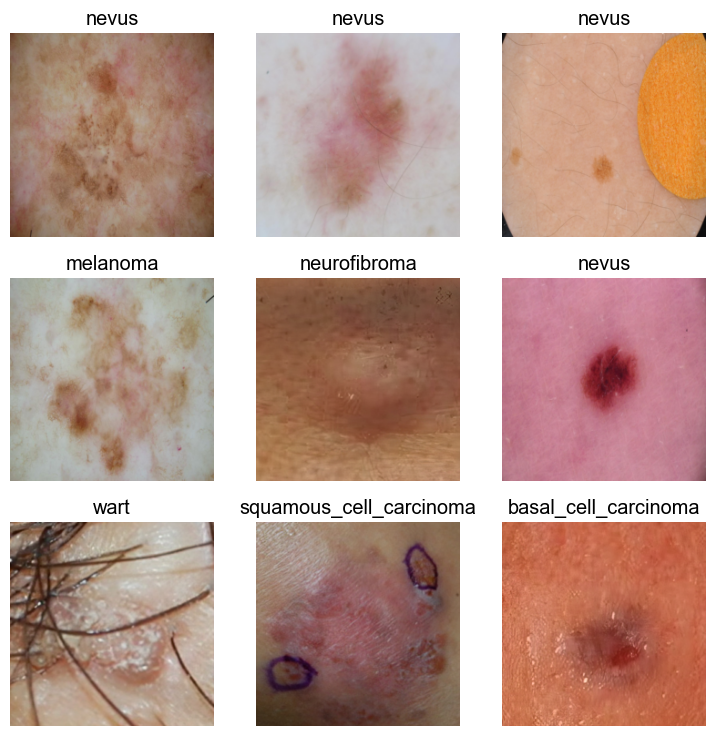

In [114]:
trainSet.show_batch()  # shows a batch of images
